In [50]:
import os 
import time 
from tqdm import tqdm 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras 
from tensorflow.keras import *
from tensorflow.keras.layers import *
import tensorflow_datasets as tfds
import pandas as pd 
from tensorflow.keras.utils import *
try:
    import tensorflow_addons as tfa 
except:
    !pip install tensorflow_addons 
    import tensorflow_addons as tda
try:
    import gdown 
except:
    !pip install gdown 
    import gdown

In [ ]:
IMG_HEIGHT = 28 
IMG_WIDTH = 28 
CHANNELS = 3 
BATCH_SIZE = 128 
NUM_CLASSES = 10 
Z_DIMS = 2

In [ ]:
url = 'https://drive.google.com/uc?id=1tCj_CKUgjtThk1fiL0wP0WiuYxk4dvjT'
tfds_rootdir = '/root/' # for Google Colab
#tfds_rootdir = '~/' # for Linux

file_path = os.path.join(tfds_rootdir, 'tensorflow_datasets/celeb_a.zip')
file_dir = file_path.replace('.zip','')
gdown.download(url, file_path, quiet=False)

!unzip $file_path -d $file_dir

(train_ds, test_ds), ds_info = tfds.load('celeb_a', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              with_info=True)

In [52]:
batch_size = 128

def preprocess(sample):
    image = sample['image']
    image = tf.image.resize(image, [112,112])
    image = tf.cast(image, tf.float32)/255.
    return image, image

train_ds = train_ds.map(preprocess)
train_ds = train_ds.shuffle(batch_size*4)
train_ds = train_ds.batch(batch_size).prefetch(batch_size)

test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(batch_size)

train_num = ds_info.splits['train'].num_examples
test_num = ds_info.splits['test'].num_examples

In [16]:
train_X = train_X / 255.0
test_X = test_X / 255.0

train_X = np.expand_dims(train_X, axis=-1)
test_X = np.expand_dims(test_X, axis=-1)

In [22]:
class GaussianSampling(Layer):        
    def call(self, inputs):
        means, logvar = inputs
        epsilon = tf.random.normal(shape=tf.shape(means), mean=0., stddev=1.)
        samples = means + tf.exp(0.5*logvar)*epsilon

        return samples
    
class DownConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), strides=1, padding='same'):
        super(DownConvBlock, self).__init__(name=f"DownConvBlock_{DownConvBlock.count}")
        DownConvBlock.count+=1
        self.forward = Sequential([Conv2D(filters, kernel_size, strides, padding)])
        self.forward.add(BatchNormalization())
        self.forward.add(layers.LeakyReLU(0.2))
        
    def call(self, inputs):
        return self.forward(inputs)

class UpConvBlock(Layer):
    count = 0
    def __init__(self, filters, kernel_size=(3,3), padding='same'):
        super(UpConvBlock, self).__init__(name=f"UpConvBlock_{UpConvBlock.count}")
        UpConvBlock.count += 1
        self.forward = Sequential([Conv2D(filters, kernel_size, 1, padding),])
        self.forward.add(layers.LeakyReLU(0.2))
        self.forward.add(UpSampling2D((2,2)))
        
    def call(self, inputs):
        return self.forward(inputs)

In [23]:
class Encoder(Layer):
    def __init__(self, z_dim, name='encoder'):
        super(Encoder, self).__init__(name=name)
        
        self.features_extract = Sequential([
            DownConvBlock(filters = 32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters = 32, kernel_size=(3,3), strides=2),
            DownConvBlock(filters = 64, kernel_size=(3,3), strides=2),
            DownConvBlock(filters = 64, kernel_size=(3,3), strides=2),
            Flatten()])
        
        self.dense_mean = Dense(z_dim, name='mean')
        self.dense_logvar = Dense(z_dim, name='logvar')
        self.sampler = GaussianSampling()
        
    def call(self, inputs):
        x = self.features_extract(inputs)
        mean = self.dense_mean(x)
        logvar = self.dense_logvar(x)
        z = self.sampler([mean, logvar])
        return z, mean, logvar


In [24]:
class Decoder(Layer):
    def __init__(self, z_dim, name='decoder'):
        super(Decoder, self).__init__(name=name)
            
        self.forward = Sequential([
                        Dense(7*7*64, activation='relu'),
                        Reshape((7,7,64)),
                        UpConvBlock(filters=64, kernel_size=(3,3)),
                        UpConvBlock(filters=64, kernel_size=(3,3)),
                        UpConvBlock(filters=32, kernel_size=(3,3)),
                        UpConvBlock(filters=32, kernel_size=(3,3)),
                        Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid'),
                
        ])

    def call(self, inputs):
        return self.forward(inputs)

In [25]:
class VAE(Model):
    def __init__(self, z_dim, name='VAE'):
        super(VAE, self).__init__(name=name)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.mean = None
        self.logvar = None
        
    def call(self, inputs):
        z, self.mean, self.logvar = self.encoder(inputs)
        out = self.decoder(z)           
        return out

In [53]:
vae_model = VAE(200)

In [54]:
def vae_kl_loss(y_true, y_pred):
    kl_loss =  - 0.5 * tf.reduce_mean(1 + vae_model.logvar - tf.square(vae_model.mean) - tf.exp(vae_model.logvar))
    return kl_loss    

def vae_rc_loss(y_true, y_pred):
    rc_loss = tf.keras.losses.MSE(y_true, y_pred)
    return rc_loss

def vae_loss(y_true, y_pred):
    kl_loss = vae_kl_loss(y_true, y_pred)
    rc_loss = vae_rc_loss(y_true, y_pred)
    kl_weight_const = 0.01
    return kl_weight_const*kl_loss + rc_loss

In [58]:
model_path = "./models/my_vae_celeb_a.h5"
os.makedirs("./models", exist_ok=True)

checkpoint = ModelCheckpoint(model_path, 
                             monitor= "vae_rc_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "vae_rc_loss", 
                      mode= "auto", 
                      patience = 3)

callbacks_list = [checkpoint, early]

initial_learning_rate = 1e-3
steps_per_epoch = int(np.round(train_num/32))
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=0.96,
    staircase=True)

vae_model.compile(
    loss = [vae_loss],
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-3),
    metrics=[vae_kl_loss,vae_rc_loss])


history = vae_model.fit(train_ds, validation_data=test_ds,
                epochs = 20, callbacks = callbacks_list)

Epoch 1/20
1272/1272 [==============================] - ETA: 0s - loss: 0.0345 - vae_kl_loss: 0.4536 - vae_rc_loss: 0.0300
Epoch 1: vae_rc_loss improved from inf to 0.02996, saving model to ./models/my_vae_celeb_a.h5
1272/1272 [==============================] - 131s 91ms/step - loss: 0.0345 - vae_kl_loss: 0.4536 - vae_rc_loss: 0.0300 - val_loss: 0.0269 - val_vae_kl_loss: 0.5139 - val_vae_rc_loss: 0.0217
Epoch 2/20
1271/1272 [============================>.] - ETA: 0s - loss: 0.0234 - vae_kl_loss: 0.4666 - vae_rc_loss: 0.0188
Epoch 2: vae_rc_loss improved from 0.02996 to 0.01876, saving model to ./models/my_vae_celeb_a.h5
1272/1272 [==============================] - 133s 104ms/step - loss: 0.0234 - vae_kl_loss: 0.4665 - vae_rc_loss: 0.0188 - val_loss: 0.0238 - val_vae_kl_loss: 0.4995 - val_vae_rc_loss: 0.0188
Epoch 3/20
1271/1272 [============================>.] - ETA: 0s - loss: 0.0213 - vae_kl_loss: 0.4450 - vae_rc_loss: 0.0168
Epoch 3: vae_rc_loss improved from 0.01876 to 0.01685, sav

4/4 [==============================] - 0s 7ms/step


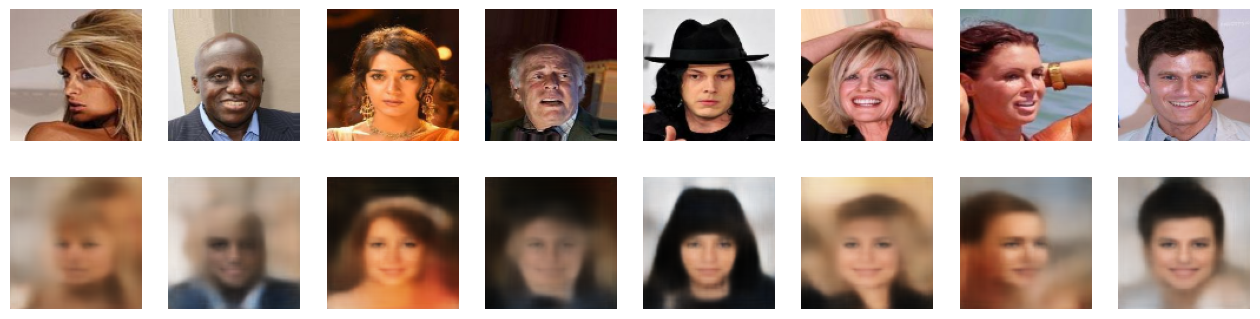

In [61]:
images, labels = next(iter(train_ds))
vae_model.load_weights(model_path)
outputs = vae_model.predict(images)

# Display
grid_col = 8
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2, grid_row*2))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i])
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i])
        axarr[row+1,col].axis('off')        
        i += 1
plt.show()